<h1 align="center"><font size="5">Capstone Project — The Battle of Neighborhoods Santiago</font></h1>

A description of the problem and a discussion of the background.

Santiago is the capital city and the largest of Chile, as well as one of the largest cities in America. It is located in the center of Chile's, and it is the most densely populated region, the Santiago Metropolitan Region, whose total population is 7 million, of which more than 6 million live in the city's continuous urban area. Given the current circumstances due to the coronavirus, Santiago is detained at a commercial and gastronomic level, therefore it is a good opportunity to analyze and determine where could be a good place to put a restaurant, due the economic rise that will be generated at the end of the coronavirus emergency, added to its fabulous characteristics, such as being a city with highest density and being the capital of the country.


Data Requirements

Datasource : https://es.wikipedia.org/wiki/Anexo:Comunas_de_Chile_por_poblaci%C3%B3n
Description: We will Scrap Santiago communes Table from Wikipedia and transform the coordinates of the major communes using in google maps. Using foursquare APIs we will get all the venues in each communes and then determine which communes are more attractive to locate a restaurant based on the different services and affluence nearly the commune.

In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install xlrd
!pip install et_xmlfile
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')
print('Folium installed')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.
Folium installed


In [11]:
df = pd.read_excel('Santiago-comunas.xlsx')
df.head()

AttributeError: 'NoneType' object has no attribute 'items'

       Commune  Surface (km2)  Population  Density (hab./km2)       Latitud  \
0     Santiago           23.2      404495             17435.1    -33°26'14"   
1    Cerrillos           21.0       80832              3849.1     -33°30'0"   
2  Cerro Navia           11.0      132622             12056.5  -33°25'19.2"   
3     Conchalí           10.7      126955             11865.0    -33°22'48"   
4    El Bosque           14.2      162505             11444.0   -33°34'1.2"   

     Longitud   Latitude  Longitude  
0  -70°39'26" -33.437222 -70.657222  
1   -70°43'0" -33.500000 -70.716667  
2   -70°44'6" -33.422000 -70.735000  
3  -70°40'30" -33.380000 -70.675000  
4  -70°40'30" -33.567000 -70.675000  

In [15]:
Santiago=df.drop(['Latitud','Longitud'], axis=1)
Santiago

AttributeError: 'NoneType' object has no attribute 'items'

                Commune  Surface (km2)  Population  Density (hab./km2)  \
0              Santiago           23.2      404495             17435.1   
1             Cerrillos           21.0       80832              3849.1   
2           Cerro Navia           11.0      132622             12056.5   
3              Conchalí           10.7      126955             11865.0   
4             El Bosque           14.2      162505             11444.0   
5      Estación Central           15.0      147041              9802.7   
6            Huechuraba           44.8       98671              2202.5   
7         Independencia            7.0      100281             14325.9   
8           La Cisterna           10.0       90119              9011.9   
9            La Florida           70.2      366916              5226.7   
10            La Granja           10.0      116571             11657.1   
11           La Pintana           30.6      177335              5795.3   
12             La Reina           23.0

In [8]:
address = 'Santiago,Chile'

geolocator = Nominatim(user_agent="Santiago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Santiago are {}, {}.'.format(latitude, longitude))

# create map of Manhattan using latitude and longitude values
map_Santiago = folium.Map(location=[latitude,longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Santiago['Latitude'], Santiago['Longitude'], Santiago['Commune']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Santiago)  
    
map_Santiago

In [120]:
CLIENT_ID = '33ILOX1VI4GKW1L4ZW2CKQOA4FKO2Y00QITHWJD3M13X0YLR' # your Foursquare ID
CLIENT_SECRET = '2ZMRL0GNNIYGYKLDACHANLS12MNNOFAHBJP02CRB4A1EUUTE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 33ILOX1VI4GKW1L4ZW2CKQOA4FKO2Y00QITHWJD3M13X0YLR
CLIENT_SECRET:2ZMRL0GNNIYGYKLDACHANLS12MNNOFAHBJP02CRB4A1EUUTE


In [121]:
df.loc[22, 'Commune']

'Providencia'

In [122]:
Commune_latitude = Santiago.loc[22, 'Latitude'] # commune latitude value
Commune_longitude = Santiago.loc[22, 'Longitude'] # commune longitude value

Commune_name = Santiago.loc[22, 'Commune'] # commune name

print('Latitude and longitude values of {} are {}, {}.'.format(Commune_name, 
                                                               Commune_latitude, 
                                                               Commune_longitude))

Latitude and longitude values of Providencia are -33.435, -70.616.


In [123]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Commune_latitude, 
    Commune_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [124]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [125]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Galleteria de Laura R,Bakery,-33.434894,-70.616581
1,Bao Bar (By Ruca),Chinese Restaurant,-33.436451,-70.616302
2,Pizzería Italia,Pizza Place,-33.437490,-70.615923
3,Jewel of India,Indian Restaurant,-33.437270,-70.616284
4,Capicúa Sandwich & Bar,Sandwich Place,-33.434960,-70.616509


In [126]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

24 venues were returned by Foursquare.


In [127]:
print ('{} unique categories in Providencia'.format(nearby_venues['categories'].value_counts().shape[0]))

19 unique categories in Providencia


In [128]:
print (nearby_venues['categories'].value_counts()[0:10])

Pizza Place                        4
Sandwich Place                     2
Peruvian Restaurant                2
Pool Hall                          1
Gym                                1
Southern / Soul Food Restaurant    1
Café                               1
South American Restaurant          1
Gastropub                          1
Coffee Shop                        1
Name: categories, dtype: int64


In [129]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [130]:
Santiago_venues = getNearbyVenues(names=Santiago['Commune'],
                                   latitudes=Santiago['Latitude'],
                                   longitudes=Santiago['Longitude']
                                  )

Santiago
Cerrillos
Cerro Navia
Conchalí
El Bosque
Estación Central
Huechuraba
Independencia
La Cisterna
La Florida
La Granja
La Pintana
La Reina
Las Condes
Lo Barnechea
Lo Espejo
Lo Prado
Macul
Maipú
Ñuñoa
Pedro Aguirre Cerda
Peñalolén
Providencia
Pudahuel
Quilicura
Quinta Normal
Recoleta
Renca
San Joaquín
San Miguel
San Ramón
Vitacura


In [131]:
Santiago_Venues_only_restaurant = Santiago_venues[Santiago_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Santiago_Venues_only_restaurant.index = np.arange(1, len(Santiago_Venues_only_restaurant )+1)

In [132]:
print (Santiago_Venues_only_restaurant['Venue Category'].value_counts())

Restaurant                         22
Sushi Restaurant                   18
Chinese Restaurant                 17
Peruvian Restaurant                13
Fast Food Restaurant                9
South American Restaurant           8
Japanese Restaurant                 7
Italian Restaurant                  6
Seafood Restaurant                  3
Asian Restaurant                    3
French Restaurant                   2
Mediterranean Restaurant            2
Latin American Restaurant           2
Indian Restaurant                   2
Arepa Restaurant                    1
Greek Restaurant                    1
Southern / Soul Food Restaurant     1
Thai Restaurant                     1
Falafel Restaurant                  1
Argentinian Restaurant              1
American Restaurant                 1
Tapas Restaurant                    1
Name: Venue Category, dtype: int64


In [133]:
print('There are {} uniques categories.'.format(len(Santiago_Venues_only_restaurant['Venue Category'].unique())))

There are 22 uniques categories.


In [134]:
Santiago_5_Commune_Venues_Top10 = Santiago_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
Santiago_5_Commune_Venues_Top10=Santiago_5_Commune_Venues_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Santiago_5_Commune_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Santiago_5_Commune_Venues_Top10

,Venue_Category,Frequency
0,Restaurant,22
1,Sushi Restaurant,18
2,Chinese Restaurant,17
3,Peruvian Restaurant,13
4,Fast Food Restaurant,9
5,South American Restaurant,8
6,Japanese Restaurant,7
7,Italian Restaurant,6
8,Seafood Restaurant,3
9,Asian Restaurant,3


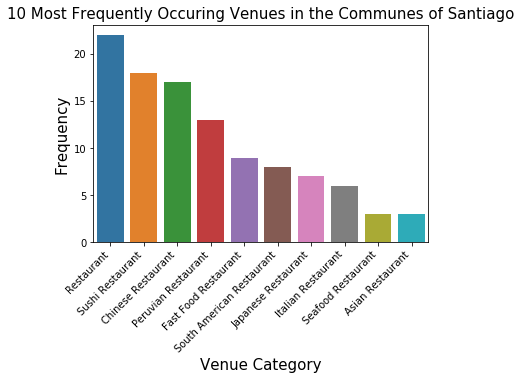

<Figure size 1296x504 with 0 Axes>

In [135]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=Santiago_5_Commune_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in the Communes of Santiago', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
fig = plt.figure(figsize=(18,7))
plt.show()


In [136]:
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Santiago_Venues_only_restaurant.shape)
Santiago_Venues_only_restaurant.head(10)

Shape of the Data-Frame with Venue Category only Restaurant:  (122, 7)


,Commune,Commune Latitude,Commune Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Santiago,-33.437222,-70.657222,Bambudda,-33.438987,-70.655631,Asian Restaurant
2,Santiago,-33.437222,-70.657222,Amanda's,-33.439206,-70.658247,Arepa Restaurant
3,Santiago,-33.437222,-70.657222,La Leyenda Peruana,-33.437977,-70.654662,Peruvian Restaurant
4,Santiago,-33.437222,-70.657222,Sushi Irasaki,-33.438396,-70.657947,Asian Restaurant
5,Santiago,-33.437222,-70.657222,Baku Sushi Restaurant - Delivery,-33.436381,-70.657044,Sushi Restaurant
6,Santiago,-33.437222,-70.657222,Estrella Marina,-33.439011,-70.656681,Peruvian Restaurant
7,Santiago,-33.437222,-70.657222,Sushi Centro,-33.433937,-70.655946,Sushi Restaurant
8,Santiago,-33.437222,-70.657222,Don Mr. Shawarma,-33.435875,-70.657974,Falafel Restaurant
9,Santiago,-33.437222,-70.657222,Kaoru Sushi,-33.438060,-70.657734,Sushi Restaurant
10,Santiago,-33.437222,-70.657222,Cruz Coke,-33.439482,-70.655382,Mediterranean Restaurant


In [137]:
Santiago_Venues_restaurant = Santiago_Venues_only_restaurant.groupby(['Commune'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())

In [138]:
Santiago_Venues_restaurant

Commune
Cerrillos            2
Conchalí             1
Estación Central     3
Huechuraba           1
La Cisterna          6
La Pintana           1
La Reina             4
Las Condes          10
Lo Barnechea         6
Lo Prado             4
Macul                3
Maipú                2
Peñalolén            2
Providencia          6
Pudahuel             2
Quilicura            6
Recoleta             1
San Miguel          10
Santiago            28
Vitacura            15
Ñuñoa                9
Name: Venue Category, dtype: int64

In [139]:
Santiago_Venues_restaurant_df  = Santiago_Venues_restaurant.to_frame().reset_index()
Santiago_Venues_restaurant_df.columns = ['Commune', 'Number of Restaurant']
Santiago_Venues_restaurant_df.index = np.arange(1, len(Santiago_Venues_restaurant_df)+1)
list_rest_no =Santiago_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =Santiago_Venues_restaurant_df['Commune'].to_list()
#print (list_rest_no)
#print (list_dist)


In [140]:
# one hot encoding
Santiago_onehot = pd.get_dummies(Santiago_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Santiago_onehot['Commune'] = Santiago_Venues_only_restaurant['Commune'] 

# move neighborhood column to the first column
fixed_columns = [Santiago_onehot.columns[-1]] + list(Santiago_onehot.columns[:-1])
Santiago_onehot = Santiago_onehot[fixed_columns]

Santiago_onehot.head()

,Commune,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Latin American Restaurant,Mediterranean Restaurant,Peruvian Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant
1,Santiago,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Santiago,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Santiago,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Santiago,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [141]:
Santiago_onehot.shape

(122, 23)

In [142]:
Santiago_grouped = Santiago_onehot.groupby('Commune').mean().reset_index()
Santiago_grouped

,Commune,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,...,Latin American Restaurant,Mediterranean Restaurant,Peruvian Restaurant,Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant
0,Cerrillos,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Conchalí,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Estación Central,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Huechuraba,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,La Cisterna,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,0.166667,0.000000,0.000000,...,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
5,La Pintana,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
6,La Reina,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
7,Las Condes,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Lo Barnechea,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.0,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.333333,0.000000,0.166667
9,Lo Prado,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000


In [143]:
Santiago_grouped.shape

(21, 23)

In [144]:
num_top_venues = 5

for hood in Santiago_grouped['Commune']:
    print("----"+hood+"----")
    temp = Santiago_grouped[Santiago_grouped['Commune'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cerrillos----
                       venue  freq
0       Fast Food Restaurant   0.5
1                 Restaurant   0.5
2        American Restaurant   0.0
3  Latin American Restaurant   0.0
4           Tapas Restaurant   0.0


----Conchalí----
                       venue  freq
0       Fast Food Restaurant   1.0
1        American Restaurant   0.0
2  Latin American Restaurant   0.0
3           Tapas Restaurant   0.0
4           Sushi Restaurant   0.0


----Estación Central----
                       venue  freq
0        Japanese Restaurant  0.33
1     Argentinian Restaurant  0.33
2                 Restaurant  0.33
3  Latin American Restaurant  0.00
4           Tapas Restaurant  0.00


----Huechuraba----
                 venue  freq
0           Restaurant   1.0
1  American Restaurant   0.0
2     Arepa Restaurant   0.0
3     Tapas Restaurant   0.0
4     Sushi Restaurant   0.0


----La Cisterna----
                  venue  freq
0      Sushi Restaurant  0.33
1    Chinese Restaurant  0.33

In [145]:

#First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [146]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Commune']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Commune_venues_sorted = pd.DataFrame(columns=columns)
Commune_venues_sorted['Commune'] = Santiago_grouped['Commune']

for ind in np.arange(Santiago_grouped.shape[0]):
    Commune_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Santiago_grouped.iloc[ind, :], num_top_venues)

Commune_venues_sorted.head(23)

,Commune,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cerrillos,Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant
1,Conchalí,Fast Food Restaurant,Thai Restaurant,Tapas Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant,Greek Restaurant
2,Estación Central,Argentinian Restaurant,Restaurant,Japanese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant
3,Huechuraba,Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
4,La Cisterna,Sushi Restaurant,Chinese Restaurant,Peruvian Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant
5,La Pintana,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
6,La Reina,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
7,Las Condes,Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant
8,Lo Barnechea,Sushi Restaurant,Thai Restaurant,Restaurant,Japanese Restaurant,French Restaurant,Greek Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant
9,Lo Prado,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant


In [147]:
# set number of clusters
kclusters = 5

Santiago_grouped_clustering = Santiago_grouped.drop('Commune', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Santiago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 4, 1, 4, 2, 2, 1, 4, 2], dtype=int32)

In [148]:
# add clustering labels

Commune_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Santiago_merged = Santiago

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Santiago_merged = Santiago_merged.join(Commune_venues_sorted.set_index('Commune'), on='Commune')

Santiago_merged# check the last columns!

,Commune,Surface (km2),Population,Density (hab./km2),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Santiago,23.2,404495,17435.1,-33.437222,-70.657222,4.0,Peruvian Restaurant,Sushi Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Chinese Restaurant,South American Restaurant,Italian Restaurant,Fast Food Restaurant,Arepa Restaurant
1,Cerrillos,21.0,80832,3849.1,-33.500000,-70.716667,1.0,Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant
2,Cerro Navia,11.0,132622,12056.5,-33.422000,-70.735000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Conchalí,10.7,126955,11865.0,-33.380000,-70.675000,3.0,Fast Food Restaurant,Thai Restaurant,Tapas Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant,Greek Restaurant
4,El Bosque,14.2,162505,11444.0,-33.567000,-70.675000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Estación Central,15.0,147041,9802.7,-33.459000,-70.699000,4.0,Argentinian Restaurant,Restaurant,Japanese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant
6,Huechuraba,44.8,98671,2202.5,-33.368000,-70.634000,1.0,Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
7,Independencia,7.0,100281,14325.9,-33.413000,-33.413000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,La Cisterna,10.0,90119,9011.9,-33.529000,-70.663000,4.0,Sushi Restaurant,Chinese Restaurant,Peruvian Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant
9,La Florida,70.2,366916,5226.7,-33.525000,-70.538000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
Santiagofinal = Santiago_merged.drop([2,4,7,9,10,15,20,25,27,28,30])

In [152]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000']
#Districts = ['Nagatacho', 'Nihonbashi', 'Shinjuku', 'Shinagawa', 'Shibuya']

# add markers to the map
for lat, lon, poi, cluster in zip(Santiagofinal['Latitude'], 
                                  Santiagofinal['Longitude'], 
                                  Santiagofinal['Commune'], 
                                  Santiagofinal['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

In [157]:
Santiagofinal.loc[Santiagofinal['Cluster Labels'] == 0, Santiagofinal.columns[[0] + list(range(4, Santiagofinal.shape[1]))]]

,Commune,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Peñalolén,-33.486189,-70.533333,0.0,South American Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant


In [158]:
Santiagofinal.loc[Santiagofinal['Cluster Labels'] == 1, Santiagofinal.columns[[0] + list(range(4, Santiagofinal.shape[1]))]]

,Commune,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Cerrillos,-33.500000,-70.716667,1.0,Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant
6,Huechuraba,-33.368000,-70.634000,1.0,Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
13,Las Condes,-33.416667,-70.583333,1.0,Restaurant,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant
17,Macul,-33.487000,-70.604000,1.0,Restaurant,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant


In [159]:
Santiagofinal.loc[Santiagofinal['Cluster Labels'] == 2, Santiagofinal.columns[[0] + list(range(4, Santiagofinal.shape[1]))]]

,Commune,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,La Pintana,-33.583000,-70.634000,2.0,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
12,La Reina,-33.443000,-70.532000,2.0,Sushi Restaurant,Italian Restaurant,Chinese Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
16,Lo Prado,-33.445000,-70.726000,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
23,Pudahuel,-33.433333,-70.716667,2.0,Sushi Restaurant,Chinese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant
26,Recoleta,-33.406000,-70.640000,2.0,Sushi Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant


In [160]:
Santiagofinal.loc[Santiagofinal['Cluster Labels'] == 3, Santiagofinal.columns[[0] + list(range(4, Santiagofinal.shape[1]))]]

,Commune,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Conchalí,-33.380000,-70.675000,3.0,Fast Food Restaurant,Thai Restaurant,Tapas Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant,Greek Restaurant
18,Maipú,-33.516667,-70.766667,3.0,American Restaurant,Fast Food Restaurant,Tapas Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,French Restaurant,Greek Restaurant


In [161]:
Santiagofinal.loc[Santiagofinal['Cluster Labels'] == 4, Santiagofinal.columns[[0] + list(range(4, Santiagofinal.shape[1]))]]

,Commune,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Santiago,-33.437222,-70.657222,4.0,Peruvian Restaurant,Sushi Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Chinese Restaurant,South American Restaurant,Italian Restaurant,Fast Food Restaurant,Arepa Restaurant
5,Estación Central,-33.459000,-70.699000,4.0,Argentinian Restaurant,Restaurant,Japanese Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Asian Restaurant,Chinese Restaurant,Falafel Restaurant,Fast Food Restaurant
8,La Cisterna,-33.529000,-70.663000,4.0,Sushi Restaurant,Chinese Restaurant,Peruvian Restaurant,Fast Food Restaurant,Thai Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Falafel Restaurant
14,Lo Barnechea,-33.350000,-70.516667,4.0,Sushi Restaurant,Thai Restaurant,Restaurant,Japanese Restaurant,French Restaurant,Greek Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant
19,Ñuñoa,-33.454000,-70.604000,4.0,Chinese Restaurant,Italian Restaurant,South American Restaurant,Restaurant,Fast Food Restaurant,Tapas Restaurant,Greek Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant
22,Providencia,-33.435000,-70.616000,4.0,Peruvian Restaurant,Southern / Soul Food Restaurant,South American Restaurant,Chinese Restaurant,Indian Restaurant,Thai Restaurant,Greek Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant
24,Quilicura,-33.361000,-70.729000,4.0,Sushi Restaurant,Seafood Restaurant,Restaurant,Peruvian Restaurant,Chinese Restaurant,Thai Restaurant,Greek Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant
29,San Miguel,-33.485833,-70.649444,4.0,Latin American Restaurant,Chinese Restaurant,Sushi Restaurant,South American Restaurant,Seafood Restaurant,Restaurant,Peruvian Restaurant,Japanese Restaurant,Thai Restaurant,Fast Food Restaurant
31,Vitacura,-33.400000,-70.600000,4.0,Restaurant,Peruvian Restaurant,Italian Restaurant,French Restaurant,South American Restaurant,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Arepa Restaurant,Argentinian Restaurant
